This notebook calculates coherence 3 ways at a point over time.
1. formula 1: 
2. formula 2: 
3. formula 3:

started organizing this on 9-28-22

***

Import things. Use conda environment oliviaJupyter.

In [1]:
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib  widget

In [2]:
# how many dates do we have? 
workdir = '/data/ocp4/LagunaSalada/'
alooks=4
rlooks=20
#cropdir='cropped_9000_20_10000_1780/'
cropdir='cropped_9000_1800_18000_3600/'

pixx=15070
pixy=1550

dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
print(str(len(dates))+' dates so far!')
nd=len(dates)

0 dates so far!


In [3]:
# initializing empty arrays, they are 3 dimensional 
# will contain a layer for each date with layer containing alooks x rlooks pixels from each SLC
slcsvv=np.ndarray([len(dates),alooks,rlooks],'complex')
slcsvh=np.ndarray([len(dates),alooks,rlooks],'complex')

# pull out the alooks x rlooks box of pixels from each SLC 
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", gdal.GA_ReadOnly)
    slcsvv[i,:,:] = ds.GetRasterBand(1).ReadAsArray(pixx-rlooks/2,pixy-alooks/2,rlooks,alooks)


for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vh/"+dates[i]+"/"+dates[i]+".slc.full", gdal.GA_ReadOnly)
    slcsvh[i,:,:] = ds.GetRasterBand(1).ReadAsArray(pixx-rlooks/2,pixy-alooks/2,rlooks,alooks)
    # center of area is pixx, pixy and pulling out rlooks wide by alooks tall 


In [4]:
# initialize empty nd x nd array for storing coherence values for each SLC pair/igram
allcovsvv=np.zeros([nd,nd])
allphasevv=np.zeros([nd,nd])
allcovsvv2=np.zeros([nd,nd])
allcovsvv3=np.zeros([nd,nd])
allcovsvh=np.zeros([nd,nd])

# assigning integer values to SLC pairs 
numints = np.cumsum(np.arange(nd))
numints=np.max(numints)
# what does this do?
ids=np.ndarray([numints,2])

# making interferograms, looping thru i, j dates 
for i in np.arange(nd-1):
    for j in np.arange(i+1,nd):
        # i is first date, j is comparison dates
        # calculating a whole row of the triangle plot at a time
        
        # first way of doing it: <a b*> / <abs(a b*)>
        # a b*
        ints=slcsvv[i,:,:] * np.conj(slcsvv[j,:,:])
        # take the mean over all the pixels in this area (complex space)
        # <a b*>
        cov=np.mean(ints,axis=(0,1))
        # <abs (a b*)>
        intmag=np.mean(np.abs(ints),axis=(0,1))
        # coherence magnitude, simplest way of doing it 
        # <a b*> / <abs(a b*)>
        covw = cov/intmag
        
        # covw is complex
        # just taking magnitude 
        allcovsvv[i,j]=np.abs(covw)
        # angle instead of mag
        allphasevv[i,j]=np.angle(covw)
        
        
        # second way of doing it: <a b*> / sqrt(<a a*> <b b*>)
        # weighted avg of one 
        aa = slcsvv[i,:,:] * np.conj(slcsvv[i,:,:])
        aa = np.mean(aa,axis=(0,1))
        bb = slcsvv[j,:,:] * np.conj(slcsvv[j,:,:])
        bb = np.mean(bb,axis=(0,1))
        covw2 = cov/np.sqrt(aa*bb)
        allcovsvv2[i,j]=np.abs(covw2)
        
        
        # third way of doing it: < (a b*) / abs(a b*) >
        #
        covw3 = np.mean(ints/np.abs(ints))
        allcovsvv3[i,j]=np.abs(covw3)
        
        
        # VH not great in my area, can comment this out 
        #ints=slcsvh[i,:,:] * np.conj(slcsvh[j,:,:])
        #cov=np.mean(ints,axis=(0,1))
        #intmag=np.mean(np.abs(ints),axis=(0,1))
        #covw = cov/intmag
        #allcovsvh[i,j]=np.abs(covw)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
print(dates[0:201:100])

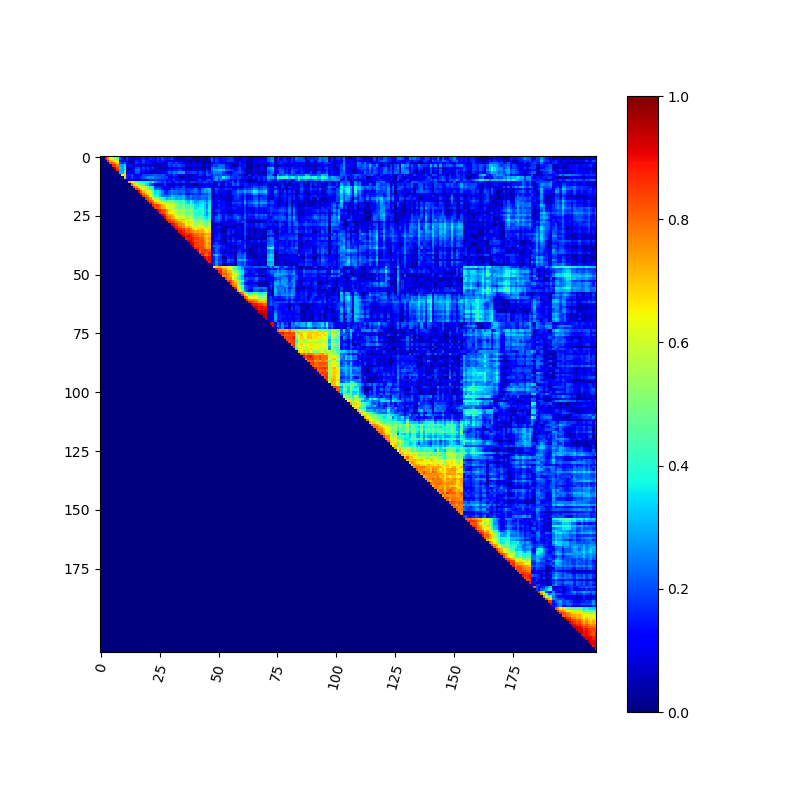

In [ ]:
# these are all different methods of plotting VV coherence 
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
ax.set_xticks((0,25,50,75,100,125,150,175))
plt.xticks(rotation = 75)
#ax.set_xticklabels(dates[0:201:25])
ax.set_yticks((0,25,50,75,100,125,150,175))
#ax.set_yticklabels(dates[0:201:25])
plt.imshow(allcovsvv2,vmin=0, vmax=1, cmap='jet',interpolation='nearest')
plt.colorbar()
plt.show()

#plt.subplot(3,1,2)
#plt.imshow(allcovsvv2,vmin=0, vmax=1,cmap='jet',interpolation='nearest')
#plt.colorbar()

#plt.subplot(3,1,3)
#plt.imshow(allcovsvv3,vmin=0, vmax=1,cmap='jet',interpolation='nearest')
#plt.colorbar()
#plt.show()

# this is for VH
#plt.subplot(2, 1, 2)
#plt.imshow(allcovsvh,vmin=0, vmax=1, cmap='jet',interpolation='nearest')
